# コンピュータにベイズ推論をさせる


In [8]:
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


In [9]:
from os import makedirs
makedirs("data", exist_ok=True)

from urllib.request import urlretrieve
urlretrieve("https://git.io/vXTVC", "data/txtdata.csv")

('data/txtdata.csv', <http.client.HTTPMessage at 0x2aabdfb3e10>)

<Container object of 74 artists>

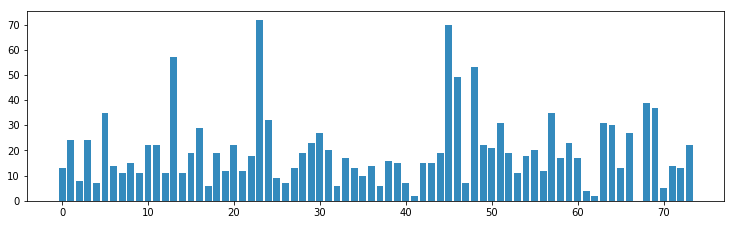

In [12]:
figsize(12.5, 3.5)

count_data = np.loadtxt("data/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")


グラフを前半と後半に分ける。その場所をswitch pointと呼ぶ。
$$ \lambda = 	\begin{eqnarray}
\left\{
\begin{array}{l}
\lambda_1 (t < \tau のとき) \\
\lambda_2 (t \geq \tau  のとき)
\end{array}
\right.
\end{eqnarray} $$